In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# %matplotlib qt
%matplotlib inline


In [2]:

def get_pixel_density_histogram(img):
    bottom_area = img[img.shape[0] // 3:, :]
    return np.sum(bottom_area, axis=0)


def get_normalized_pivots(img, left_pivot, right_pivot):
    midpoint = np.int(img.shape[0] / 2)
    space_between = np.int(img.shape[0] - (img.shape[0] / 3))
    most_dense = max(left_pivot, right_pivot)
    if most_dense > midpoint:
        left_pivot = right_pivot - space_between
    if most_dense < midpoint:
        right_pivot = left_pivot + space_between
    return left_pivot, right_pivot



def pixel_density_polynomial_curve_fit(img,
                                       rectangle_count=20,
                                       rect_width=75,
                                       rectangle_visible=False,
                                       min_pixel_density=100):
    out_img = np.dstack((img, img, img)) * 255
    rect_height = np.int(img.shape[0] / rectangle_count)

    nonzero = img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    pixel_density_histogram = get_pixel_density_histogram(img)

    midpoint = np.int(pixel_density_histogram.shape[0] / 2)
    left_pivot, right_pivot = get_normalized_pivots(img,
                                                    np.argmax(pixel_density_histogram[:midpoint]),
                                                    np.argmax(pixel_density_histogram[midpoint:]) + midpoint)
    left_path_index = []
    right_path_index = []

    # Step through the rectangles one by one
    for rectangle in range(rectangle_count):

        # Identify rectangle boundaries in x and y (and right and left)
        rect_y_bottom = img.shape[0] - (rectangle + 1) * rect_height
        rect_y_top = img.shape[0] - rectangle * rect_height
        rect_x_left_bottom = left_pivot - rect_width
        rect_x_left_top = left_pivot + rect_width
        rect_x_right_bottom = right_pivot - rect_width
        rect_x_right_top = right_pivot + rect_width

        # Identify the nonzero pixels in x and y within the rectangle
        left_rect_area = ((nonzero_y >= rect_y_bottom) &
                          (nonzero_y < rect_y_top) &
                          (nonzero_x >= rect_x_left_bottom) &
                          (nonzero_x < rect_x_left_top)).nonzero()[0]

        right_rect_area = ((nonzero_y >= rect_y_bottom) &
                           (nonzero_y < rect_y_top) &
                           (nonzero_x >= rect_x_right_bottom) &
                           (nonzero_x < rect_x_right_top)).nonzero()[0]

        # If you found > min_pixel_density, recenter next rectangle on their mean position
        if len(left_rect_area) > min_pixel_density:
            left_pivot, right_pivot = get_normalized_pivots(
                img, np.int(np.mean(nonzero_x[left_rect_area])), right_pivot)
        if len(right_rect_area) > min_pixel_density:
            left_pivot, right_pivot = get_normalized_pivots(
                img, left_pivot, np.int(np.mean(nonzero_x[right_rect_area])))

        # append these indices to the lists
        left_path_index.append(left_rect_area)
        right_path_index.append(right_rect_area)

        # Draw the windows on the visualization image
        if rectangle_visible:
            cv2.rectangle(out_img, (rect_x_left_bottom, rect_y_bottom), (rect_x_left_top, rect_y_top), (0, 255, 0), 2)
            cv2.rectangle(out_img, (rect_x_right_bottom, rect_y_bottom), (rect_x_right_top, rect_y_top), (0, 255, 0), 2)

    # Concatenate the arrays of indices
    left_path_index = np.concatenate(left_path_index)
    right_path_index = np.concatenate(right_path_index)

    # save image
    out_img[nonzero_y[left_path_index], nonzero_x[left_path_index]] = [255, 255, 0]
    out_img[nonzero_y[right_path_index], nonzero_x[right_path_index]] = [255, 255, 0]

    # Extract left and right line pixel positions
    left_x = nonzero_x[left_path_index]
    left_y = nonzero_y[left_path_index]
    right_x = nonzero_x[right_path_index]
    right_y = nonzero_y[right_path_index]

    # Generate x and y values for plotting
    plot_y = np.linspace(0, out_img.shape[0] - 1, out_img.shape[0])
    lane_width = 100
    lane_img = np.zeros_like(out_img)

    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(left_y, left_x, 2)
        left_fit_x = left_fit[0] * plot_y ** 2 + left_fit[1] * plot_y + left_fit[2]
        left_lane_rect_a = np.array([np.transpose(np.vstack([left_fit_x - lane_width, plot_y]))])
        left_lane_rect_b = np.array([np.flipud(np.transpose(np.vstack([left_fit_x + lane_width, plot_y])))])
        left_lane_pts = np.hstack((left_lane_rect_a, left_lane_rect_b))
        cv2.fillPoly(lane_img, np.int_([left_lane_pts]), (255, 0, 0))
    except:
        left_fit = None

    try:
        right_fit = np.polyfit(right_y, right_x, 2)
        right_fit_x = right_fit[0] * plot_y ** 2 + right_fit[1] * plot_y + right_fit[2]
        right_lane_rect_a = np.array([np.transpose(np.vstack([right_fit_x - lane_width, plot_y]))])
        right_lane_rect_b = np.array([np.flipud(np.transpose(np.vstack([right_fit_x + lane_width, plot_y])))])
        right_lane_pts = np.hstack((right_lane_rect_a, right_lane_rect_b))
        cv2.fillPoly(lane_img, np.int_([right_lane_pts]), (0, 0, 255))
    except:
        right_fit = None

    out_img = cv2.addWeighted(out_img, 1, lane_img, 0.7, 0)
    return left_fit, right_fit, out_img

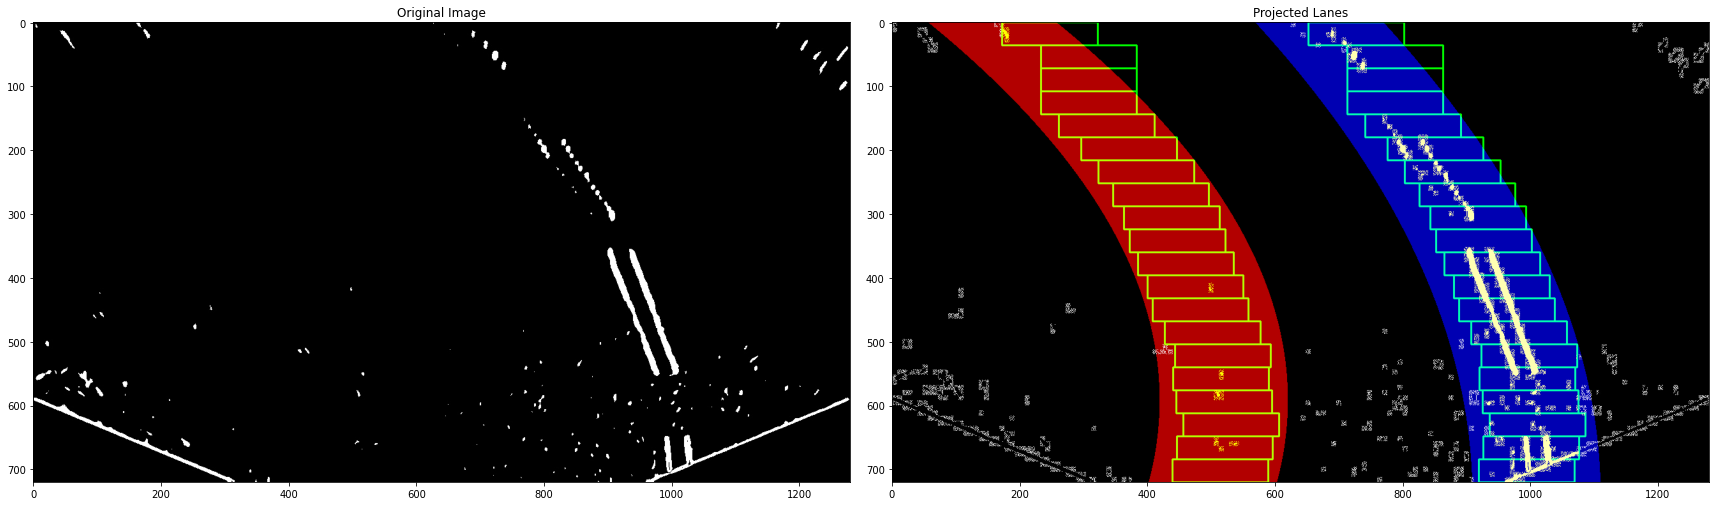

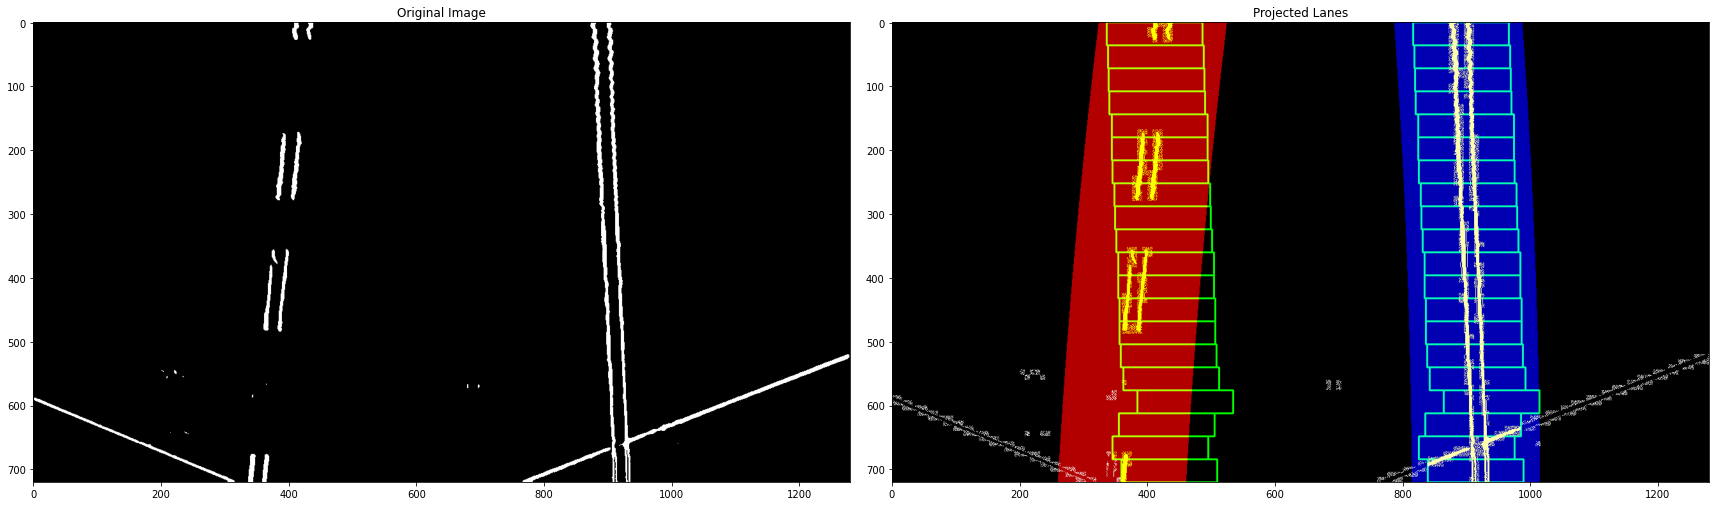

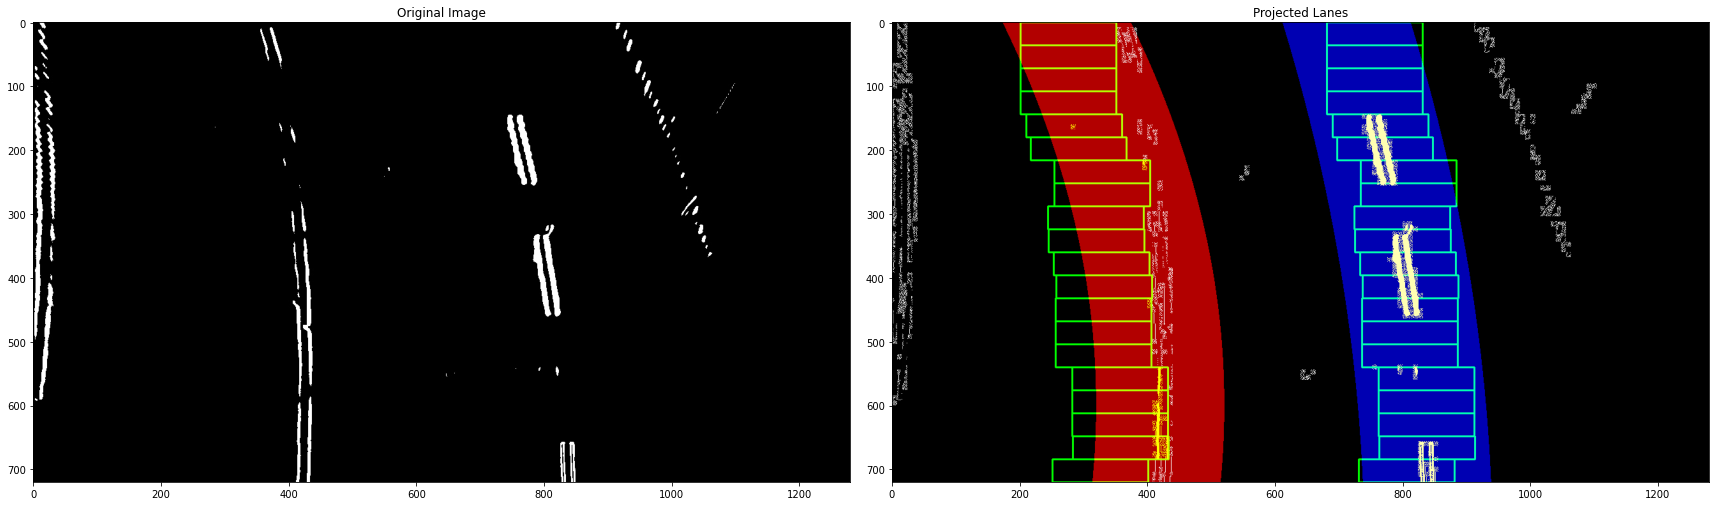

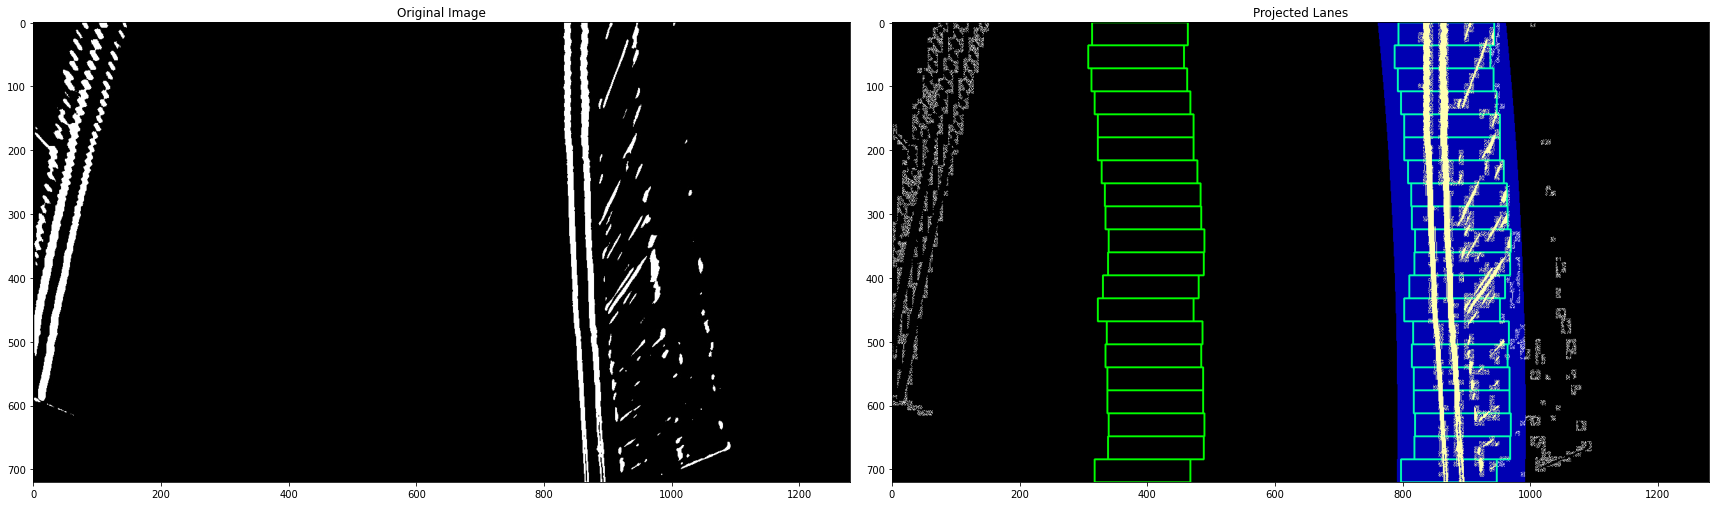

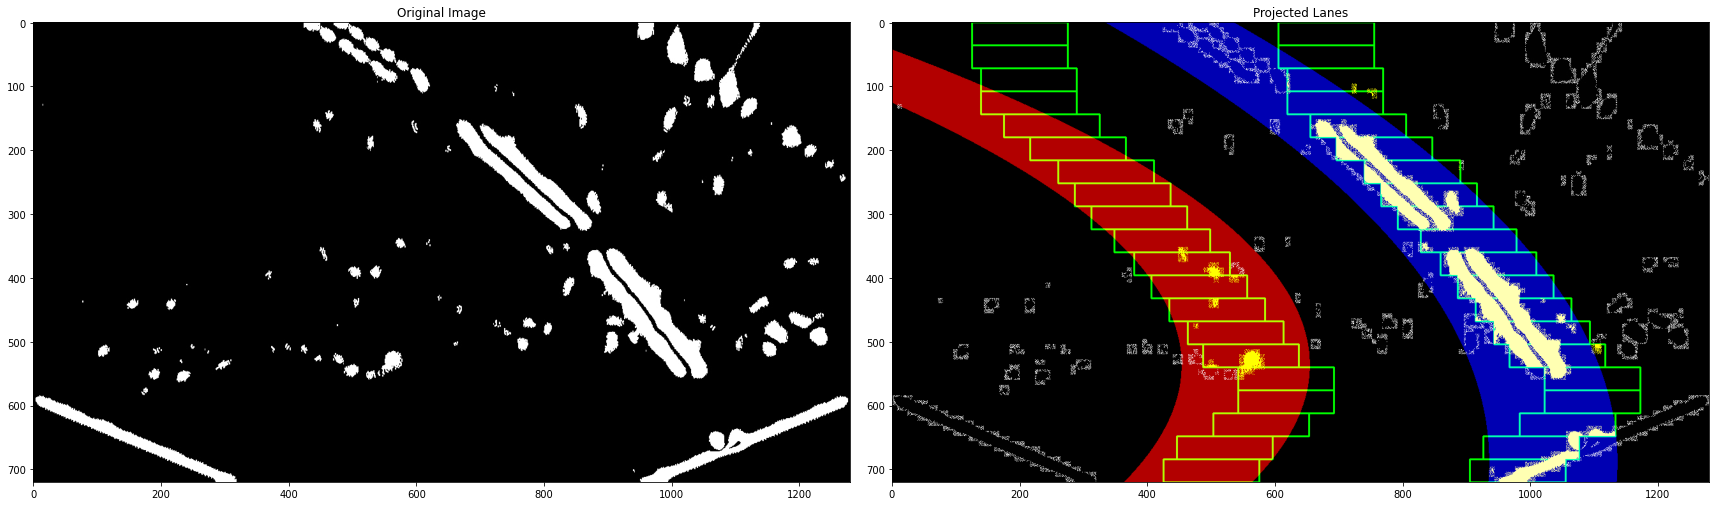

In [3]:
### get the test images from the test_images folder
images = glob.glob('./test*/lane_detection_image_edge.jpg')
        

### Loop through each image and send it to the pipeline
for fname in images:
    
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    left_fit, right_fit, out_img = pixel_density_polynomial_curve_fit(img, rectangle_visible=True)

    ### Plot the original image, the binary warped image, and the visualization from the fitter
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax2.imshow(out_img)
    ax2.set_title('Projected Lanes')
    
    ### Improvement: https://www.intmath.com/applications-differentiation/8-radius-curvature.php